# 🔬 VQE Ground State Simulation of H₂ with Ansatz Comparison (Noiseless)

This notebook implements the **Variational Quantum Eigensolver (VQE)** to compute the **ground state energy of dihydrogen (H₂)** using a **noiseless quantum simulator**. It compares the performance of multiple **variational ansatzes** to understand their expressive power and convergence behavior.

### Key Features:
- **Molecular Setup**: Defines the H₂ molecule and constructs the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Customizable Ansatz Selection**:
  - Uses a dictionary of predefined ansatzes (`ANSATZES`) including:
    - `UCCSD` (unitary coupled cluster),
    - `Minimal` (simplified configuration),
    - `RY-CZ` (hardware-efficient style).
- **VQE Execution**:
  - Runs independent VQE loops for each ansatz using the **Adam optimizer**.
  - Tracks energy at each iteration for performance comparison.

### 📊 Visualization Outputs:
- **Energy convergence plots** for each ansatz over the training iterations.
- Final ground state energies per ansatz, enabling performance benchmarking.

### Purpose:
To evaluate and compare different **ansatz strategies** for variational quantum simulations, providing insight into trade-offs between expressivity, convergence speed, and implementation complexity in near-term quantum devices.

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
# from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import ANSATZES, get_optimizer

In [3]:
# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

# Define the dihydrogen Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# Define the number of required quantum wires / logical qubits
num_wires = qubits
print(f"{qubits} qubits required")

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


def create_circuit(ansatz_fn, wires):
    @qml.qnode(dev)
    def circuit(params):
        ansatz_fn(params, wires=wires)
        return qml.expval(hamiltonian)
    return circuit

4 qubits required


In [4]:
# Run VQE for each ansatz
results = {}
max_iters = 40
stepsize = 0.2

for name, ansatz_fn in ANSATZES.items():
    print(f"\nRunning VQE with {name} Ansatz...")
    
    circuit = create_circuit(ansatz_fn, wires=[0, 1])
    cost = lambda p: circuit(p)
    
    # Guess parameter count based on ansatz name
    if name in ["UCCSD", "Minimal"]:
        num_params = 1
    elif name == "RY-CZ":
        num_params = 2

    init_params = 0.01 * np.random.randn(num_params)
    opt = get_optimizer("Adam", stepsize=0.2)
    
    params = init_params
    energy_progress = []
    for i in range(max_iters):
        params = opt.step(cost, params)
        energy = cost(params)
        energy_progress.append(energy)

    results[name] = {
        "final_energy": energy,
        "params": params,
        "trajectory": energy_progress,
    }

    print(f"Final energy for {name}: {energy:.8f} Ha")


Running VQE with UCCSD Ansatz...
Final energy for UCCSD: -0.87975488 Ha

Running VQE with RY-CZ Ansatz...
Final energy for RY-CZ: -0.87929147 Ha

Running VQE with Minimal Ansatz...
Final energy for Minimal: -0.84813960 Ha


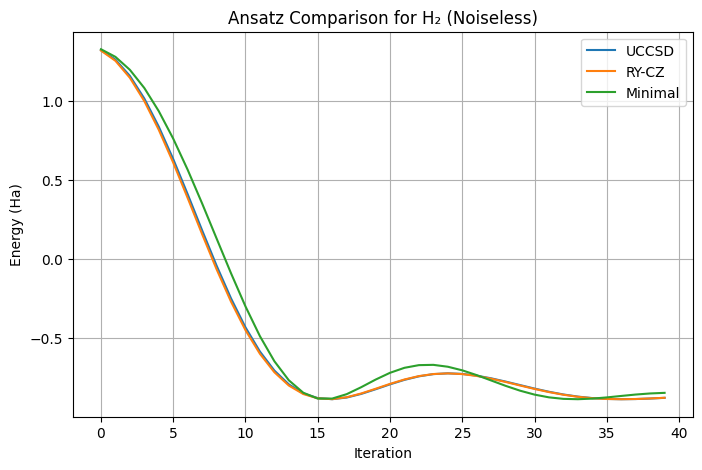

In [5]:
plt.figure(figsize=(8, 5))
for name, data in results.items():
    plt.plot(data["trajectory"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Ansatz Comparison for H₂ (Noiseless)")
plt.legend()
plt.grid(True)

# Save the figure to the "images" directory
os.makedirs("images", exist_ok=True)
plt.savefig('images/H2_Ansatz_Comparison.png')
plt.show()